<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Analysis: Text Classification, Clustering, and Regression

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens.
* Using [Folium](https://pypi.org/project/folium/), [Geopy](https://geopy.readthedocs.io/en/stable/), and [scikit-learn](https://scikit-learn.org/stable/) algorithms for hierarchical clustering, classification and regression.

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [2]:
import os

if not os.path.exists('proverbs.csv'):
    proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
    proverbs.to_csv('proverbs.csv', index=False)
else:
    proverbs = pd.read_csv('proverbs.csv')

proverbs.shape


(134493, 4)

In [3]:
proverbs.sample(3)

text                  place  \
129145             Αμαρτίαι γονέων παιδεύουσι τέκνα                Ήπειρος   
41126   Το γάιδαρο εχώνανε, τ' αυτιά την φανερώνανε  Κρήτη, Σητεία, Χαμέζι   
16718                                      Πετεινός      Νάξος, Απείρανθος   

                                              uri                   collector  
129145  http://hdl.handle.net/20.500.11853/159886                   anonymous  
41126   http://hdl.handle.net/20.500.11853/147844    Καραβιτάκης, Νικόλαος Γ.  
16718   http://hdl.handle.net/20.500.11853/245454  Ζευγώλη – Γλέζου, Διαλεχτή

* Few proverbs comrpise definitions, removing them

In [4]:
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Ήταν στην κόκκα της =A guatres epingles'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist.

In [6]:
proverbs[proverbs.duplicated()]

text  \
62809         Απού δε θέλει χτύπους στο χαρκιδιό δεν πάει   
62810   Απού δε σπείρη τον Οχτώβρη, οχτώ σωρούς δεν κάνει   
62811                     Απού διαλέει, πάει ποδιαλεμάτου   
62812   Απού δουλεύγει βασιλιά το νού ντου πρέπει νάχη...   
62813       Απού ζυμώση και πλυθή σαράντα μέρες είν' καλή   
...                                                   ...   
134488       Απ' ούλα τα φαΓια το ρύζ' και τσόχα να φορής   
134489  Απ' τ' Άη – Λιός και μπρός γυρίζει ο καιρός αλ...   
134490     Απ' τ' Άι – Ηλιά το βράδυ βάζει η ελιά το λάδι   
134491                        Απ' τ' άλουγου στου γουμάρι   
134492         Απ' τα ίδια κουμπιά κι' ολιγώτερη φαττούρα   

                                place  \
62809     Κρήτη, Αποκόρωνας, Μελιδόνι   
62810        Κρήτη, Λασίθι, Τζερμιάδο   
62811   Κρήτη, Λασίθι, Άγιος Γεώργιος   
62812                  Κρήτη, Ρέθυμνο   
62813   Κρήτη, Λασίθι, Άγιος Γεώργιος   
...                               ...   
134488                Θράκη, Σαμακόβι   
134489             Μεσσηνία, Φιλιατρά   
134490                         Σίφνος   
134491                        Ήπειρος   
134492                  Ηλεία, Πύργος   

                                              uri        collector  
62809   http://hdl.handle.net/20.500.11853/161130  Λιουδάκη, Μαρία  
62810   http://hdl.handle.net/20.500.11853/288692  Λιουδάκη, Μαρία  
62811   http://hdl.handle.net/20.500.11853/163118  Λιουδάκη, Μαρία  
62812   http://hdl.handle.net/20.500.11853/151409  Λιουδάκη, Μαρία  
62813   http://hdl.handle.net/20.500.11853/163084  Λιουδάκη, Μαρία  
...                                           ...              ...  
134488  http://hdl.handle.net/20.500.11853/245653        anonymous  
134489  http://hdl.handle.net/20.500.11853/160335        anonymous  
134490  http://hdl.handle.net/20.500.11853/190853        anonymous  
134491  http://hdl.handle.net/20.500.11853/159862        anonymous  
134492  http://hdl.handle.net/20.500.11853/199334        anonymous  

[13875 rows x 4 columns]

* There are more duplicates when considering the `text` column only.

In [7]:
num_total_duplicates = proverbs.text.duplicated().sum()
num_total_duplicates

24836

* Climbing up to the highest-level information per location labelled.

* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [8]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

text                place  \
92571  Καιρός φέρνει τα λάχανα καιρός τα παραπούλια μ...   Ιωάννινα, Καλέντζι   
95959         Σ' σο γεργάνι σ'κερέν άπλωσον τα ποδάρι σ'  Πόντος, Τραπεζούντα   
346      Από τρελλό κι από μικρό παίρεις καθάρια αλήθεια         Εύβοια, Κύμη   

                                             uri                  collector  \
92571  http://hdl.handle.net/20.500.11853/267999  Οικονομίδης, Δημήτριος Β.   
95959  http://hdl.handle.net/20.500.11853/184647   Παπαδόπουλος, Άνθιμος Α.   
346    http://hdl.handle.net/20.500.11853/140736      Αλεξανδρής, Απόστολος   

           area  
92571  Ιωάννινα  
95959    Πόντος  
346      Εύβοια

* One more observation regards proverbs with no information about their location 


In [9]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique broad areas registered in the collection

In [10]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [ ]:
#@title [optional] Geocoding

if not os.path.exists('geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα") 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
        else:
            print (loc)

    # fixing some by hand (Cyprus was mislocated too)
    location = geolocator.geocode("Cyprus")
    geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Siteia")
    geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Chania")
    geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Nafpaktia")
    geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Lepenou")
    geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Cappadocia")
    geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Imathia")
    geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Boeotia")
    geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Edirne")
    geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
    geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phthiotis")
    geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Andritsaina")
    geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Dardanelles Strait")
    geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Central Greece")
    geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Areopoli")
    geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Trifylia")
    geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phocis")
    geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("West Mani")
    geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

    pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False)

In [11]:
geolocs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

Κρήτη     Σίφνος     Σέρρες      Πήλιο    Ήπειρος    Λευκάδα  \
lat  35.308495  36.971401  41.091071  39.365088  37.998253  38.706573   
lon  24.463342  24.708110  23.549803  23.135561  23.737867  20.641709   

         Αχαΐα     Εύβοια  Μακεδονία     Κύπρος  ...  Ανατολική Θράκη  \
lat  38.069275  38.494172  40.686024  34.982302  ...        41.675933   
lon  21.872730  23.911084  23.693434  33.145128  ...        26.558722   

     Αδριανούπολη  Φθιώτιδα  Ανδρίτσαινα Ολυμπίου  Δαρδανέλλια (Ελλήσποντος)  \
lat     41.675933  38.88734             37.483836                  40.337606   
lon     26.558722  22.36803             21.905533                  26.640821   

     Στερεά Ελλάδα   Αερόπολη   Τριφυλία     Φωκίδα  Δυτική Μάνη  
lat      38.562460  36.665918  37.195013  38.499868    22.581762  
lon      23.161853  22.381635  21.703732  22.248780    88.399181  

[2 rows x 130 columns]

In [12]:
# turning it into a dict, our initial selection
geolocs = geolocs.to_dict()

* Now, updating the corpus with the mined information

In [13]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals.

In [14]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [15]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [16]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 104 locations.

In [19]:
named[named.text.duplicated()].area.unique()

array(['Εύβοια', 'Λέσβος', 'Ήπειρος', 'Ρούμελη', 'Κοζάνη', 'Αρκαδία',
       'Ίμβρος', 'Φιλιππούπολη', 'Αττική', 'Πόντος',
       'Δαρδανέλλια (Ελλήσποντος)', 'Θράκη', 'Μακεδονία', 'Κεφαλληνία',
       'Μήλος', 'Χίος', 'Μικρά Ασία', 'Κρήτη', 'Κίμωλος', 'Άνδρος',
       'Λέρος', 'Ρόδος', 'Κύπρος', 'Άρτα', 'Πρέβεζα', 'Παξοί', 'Καρδίτσα',
       'Άδηλου τόπου', 'Καστελλόριζο (Μεγίστη)', 'Αθήνα', 'Μεσσηνία',
       'Λακωνία', 'Σίφνος', 'Ηλεία', 'Σύμη', 'Θήρα (Σαντορίνη)', 'Κως',
       'Σμύρνη', 'Κάλυμνος', 'Νάξος', 'Αδριανούπολη', 'Ευρυτανία',
       'Κέρκυρα', 'Αμοργός', 'Θεσπρωτία', 'Σάμος', 'Καστοριά', 'Βοιωτία',
       'Επτάνησος', 'Νίσυρος', 'Αχαΐα', 'Κορινθία', 'Τήλος', 'Πέλλα',
       'Λάρισα', 'Κύθηρα', 'Ιωάννινα', 'Ημαθία', 'Φωκίδα', 'Πελοπόννησος',
       'Σύρος', 'Μάνη', 'Σκύρος', 'Αιτωλία', 'Κύθνος', 'Τήνος', 'Κέα',
       'Άγιον Όρος', 'Πάρος', 'Θεσσαλία', 'Μάλγαρα', 'Ανατολική Κρήτη',
       'Μαγνησία', 'Σέριφος', 'Ιθάκη', 'Λευκάδα', 'Αργολίδα',
       'Καππαδοκία', 'Ακαρναν

* We group by text the `named` duplicates , to get duplicates using items by named collectors.

In [20]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

place  \
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ήπειρος, Κόνιτσα, Βούρμπιανη, Κρήτη, Κυδωνία,...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Κρήτη, Θράκη, Αυδήμιο, Αργολίδα, Ερμιονίδα, Κ...   
Θεωρία επισκόπου και καρδιά μυλωνά              {Θράκη, Περιστερά, Κρήτη, Μικρά Ασία, Λιβίσσι ...   

                                                place_num  
text                                                       
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45  
Ανεμομαζώματα, διαβολοσκορπίσματα                      28  
Θεωρία επισκόπου και καρδιά μυλωνά                     27

* Finding the broader location, which we'll call `area`.

In [21]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

place  \
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ήπειρος, Κόνιτσα, Βούρμπιανη, Κρήτη, Κυδωνία,...   
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ιωάννινα, Χουλιαράδες, Καστοριά, Απόσκεπος, Σ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Κρήτη, Θράκη, Αυδήμιο, Αργολίδα, Ερμιονίδα, Κ...   

                                                place_num  \
text                                                        
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45   
Στου κουφού την πόρτα όσο θέλεις βρόντα                26   
Ανεμομαζώματα, διαβολοσκορπίσματα                      28   

                                                                                             area  \
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Κρήτη, Πήλιο, Θεσπρωτία, Ιωάννινα, Νάξος, Κύπ...   
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Πέλλα, Κρήτη, Φωκίδα, Σέρρες, Κεφαλληνία, Άνδ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Τήλος, Θράκη, Εύβοια, Κρήτη, Κως, Μακεδονία, ...   

                                                area_num  
text                                                      
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει        23  
Στου κουφού την πόρτα όσο θέλεις βρόντα               20  
Ανεμομαζώματα, διαβολοσκορπίσματα                     18

In [22]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [25]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [26]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

place  \
text                                                                         
Το καλό αρνί βυζαίνει δυο μαννάδες  {Ιθάκη, Κεφαλληνία, Ήπειρος, Δρόβιανη}   

                                    place_num                          area  \
text                                                                          
Το καλό αρνί βυζαίνει δυο μαννάδες          3  {Ήπειρος, Ιθάκη, Κεφαλληνία}   

                                    area_num  \
text                                           
Το καλό αρνί βυζαίνει δυο μαννάδες         3   

                                                                               latlon  
text                                                                                   
Το καλό αρνί βυζαίνει δυο μαννάδες  [(37.9982534, 23.7378671), (38.401896050000005...

In [27]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* Let's visualising the dataframe.

* We will use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note that outliers exist: Chiesa della Madona delle Neve

In [ ]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)

for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)

m.save("duplicates.html")
m

* Let's find the number of areas sharing proverbs with crowdy Athens

In [29]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [30]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


text             place  \
45889        Άλλος κάνει την τσόχα κι' άλλος τη φορεί!      Αχαΐα, Πάτρα   
36631  Θαρρείς πως έχω πλατειά τσοιλιά να βαστά πάντα;  Κορινθία, Πύργος   
11052               Αλλού τον τρώγει κι' αλλού ξύνεται          Μεσσηνία   

                                             uri                collector  \
45889  http://hdl.handle.net/20.500.11853/150284     Κορύλλος, Χρήστος Π.   
36631  http://hdl.handle.net/20.500.11853/200097     Κακριδής, Ιωάννης Θ.   
11052  http://hdl.handle.net/20.500.11853/142441  Δουκάκης, Δημήτριος Χρ.   

           area        lat        lon  
45889     Αχαΐα  38.069275  21.872730  
36631  Κορινθία  37.962991  22.733342  
11052  Μεσσηνία  36.986899  21.827125

* We'll move aside single-placed proberbs from an unknown place.

In [31]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


text         place  \
81813       Άνθρωπος του παλουκιού  Άδηλου τόπου   
84169      Ζήσε, γέρο, να μαθαίνης  Άδηλου τόπου   
103073  Το πεπρωμένον αναπόφευκτον  Άδηλου τόπου   

                                              uri       collector  \
81813   http://hdl.handle.net/20.500.11853/155362  Νεστορίδης, Κ.   
84169   http://hdl.handle.net/20.500.11853/265578  Νεστορίδης, Κ.   
103073  http://hdl.handle.net/20.500.11853/265221  Ποταγός, Ν. Ν.   

                area  lat  lon  
81813   Άδηλου τόπου  NaN  NaN  
84169   Άδηλου τόπου  NaN  NaN  
103073  Άδηλου τόπου  NaN  NaN

* We'll work with the rest.

In [32]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


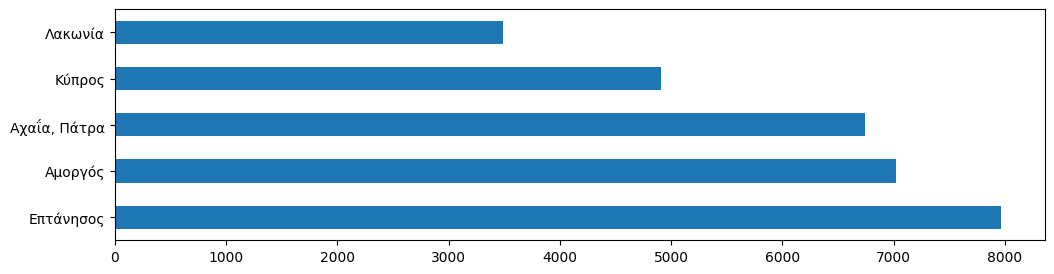

In [33]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Let's visualise the places along with the number of proverbs collected there.

In [34]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with places which have 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [35]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


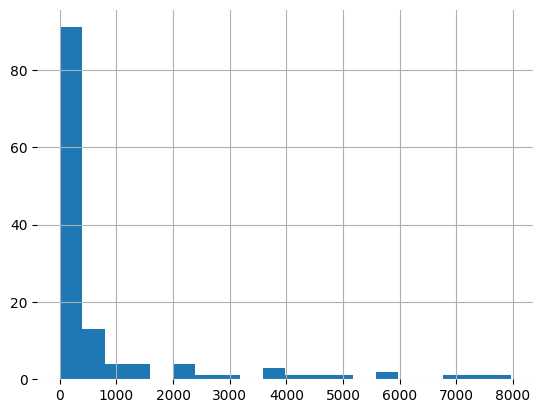

In [36]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [37]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* We'll remove proverbs with unknown (invalid?) characters.

In [38]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* We create a location-balanced corpus.

In [39]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=1, lowercase=True)
X = vect.fit_transform(long_texts)

In [45]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [46]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area  Ήπειρος  Αιτωλία  Αμοργός  Ανατολική Θράκη  Αρκαδία  Αχαΐα  Επτάνησος  \
τζ        0.0      0.0      0.0              0.0      0.0    0.0        0.0   
τζαι      0.0      0.0      0.0              0.0      0.0    0.0        0.0   
τζαί      0.0      0.0      0.0              0.0      0.0    0.0        0.0   

area   Εύβοια  Θεσπρωτία  Θράκη  ...  Κρήτη    Κύπρος  Λέσβος  Λακωνία  \
τζ    0.01721        0.0    0.0  ...    0.0  0.704103     0.0      0.0   
τζαι  0.00000        0.0    0.0  ...    0.0  0.395910     0.0      0.0   
τζαί  0.00000        0.0    0.0  ...    0.0  0.272880     0.0      0.0   

area  Μακεδονία  Μικρά Ασία  Νάξος  Πόντος  Ρόδος    Σκύρος  
τζ          0.0         0.0    0.0     0.0    0.0  0.011354  
τζαι        0.0         0.0    0.0     0.0    0.0  0.000000  
τζαί        0.0         0.0    0.0     0.0    0.0  0.012524  

[3 rows x 23 columns]

* Computing a lexicon with the terms with the highest TFIDF value per area

In [47]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
area_ngrams

{'Ήπειρος': ['τουν', 'μι', 'όλ'],
 'Αιτωλία': ['τουν', 'είνι', 'μι'],
 'Αμοργός': ['μηδέ', 'όγοιος', 'είντα'],
 'Ανατολική Θράκη': ['νε', 'αμάξι', 'νάχουν'],
 'Αρκαδία': ['κάμπους', 'κάνω', 'στις'],
 'Αχαΐα': ['γρόσι', 'τογ', 'τομ'],
 'Επτάνησος': ['ναν', 'εκειός', 'ειν'],
 'Εύβοια': ['τσαί', 'τσαι', 'βγέλλει'],
 'Θεσπρωτία': ['πάρεξ', 'ζυγό', 'ντράβαλα'],
 'Θράκη': ['πε', 'τς', 'διάβολο'],
 'Ιωάννινα': ['μι', 'σι', 'τουν'],
 'Κάρπαθος': ['τσαι', 'εγιώ', 'τσαί'],
 'Κεφαλληνία': ['τσου', 'όθεν', 'τσι'],
 'Κρήτη': ['ντου', 'καλλιά', 'τση'],
 'Κύπρος': ['τζ', 'τζαι', 'τζαί'],
 'Λέσβος': ['τσι', 'τουν', 'μι'],
 'Λακωνία': ['ςτο', 'τες', 'γλέντι'],
 'Μακεδονία': ['σι', 'μι', 'τουν'],
 'Μικρά Ασία': ['τουν', 'κη', 'σι'],
 'Νάξος': ['ια', 'τζη', 'έρο'],
 'Πόντος': ['σο', 'ατ', 'σην'],
 'Ρόδος': ['κάμνει', 'λωλλός', 'γαπά'],
 'Σκύρος': ['τσαί', 'τσαι', 'έναι']}

* Locating the important terms on the map

In [48]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [49]:
geotfidf.to_csv("geotfidf.csv")

In [50]:
pd.DataFrame(area_ngrams)

Ήπειρος Αιτωλία Αμοργός Ανατολική Θράκη  Αρκαδία  Αχαΐα Επτάνησος   Εύβοια  \
0    τουν    τουν    μηδέ              νε  κάμπους  γρόσι       ναν     τσαί   
1      μι    είνι  όγοιος           αμάξι     κάνω    τογ    εκειός     τσαι   
2      όλ      μι   είντα          νάχουν     στις    τομ       ειν  βγέλλει   

  Θεσπρωτία    Θράκη  ...   Κρήτη Κύπρος Λέσβος Λακωνία Μακεδονία Μικρά Ασία  \
0     πάρεξ       πε  ...    ντου     τζ    τσι     ςτο        σι       τουν   
1      ζυγό       τς  ...  καλλιά   τζαι   τουν     τες        μι         κη   
2  ντράβαλα  διάβολο  ...     τση   τζαί     μι  γλέντι      τουν         σι   

  Νάξος Πόντος   Ρόδος Σκύρος  
0    ια     σο  κάμνει   τσαί  
1   τζη     ατ  λωλλός   τσαι  
2   έρο    σην    γαπά   έναι  

[3 rows x 23 columns]

In [52]:
loc_name = {'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Macedonia', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}
for area in area_ngrams:
    print(f'{loc_name[area]} & {" & ".join(area_ngrams[area])} \\\\')

Epirus & τουν & μι & όλ \\
Etolia & τουν & είνι & μι \\
Amorgos & μηδέ & όγοιος & είντα \\
East Thrace & νε & αμάξι & νάχουν \\
Arcadia & κάμπους & κάνω & στις \\
Achaia & γρόσι & τογ & τομ \\
Eptanisos & ναν & εκειός & ειν \\
Eyvoia & τσαί & τσαι & βγέλλει \\
Thesprotia & πάρεξ & ζυγό & ντράβαλα \\
Thrace & πε & τς & διάβολο \\
Ioannina & μι & σι & τουν \\
Karpathos & τσαι & εγιώ & τσαί \\
Kefalinia & τσου & όθεν & τσι \\
Crete & ντου & καλλιά & τση \\
Cyprus & τζ & τζαι & τζαί \\
Lesvos & τσι & τουν & μι \\
Laconia & ςτο & τες & γλέντι \\
Macedonia & σι & μι & τουν \\
Asia Minor & τουν & κη & σι \\
Naxos & ια & τζη & έρο \\
Pontos & σο & ατ & σην \\
Rodos & κάμνει & λωλλός & γαπά \\
Skyros & τσαί & τσαι & έναι \\


# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [53]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [ ]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

In [55]:
# building the local language models
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))

In [56]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [57]:
# use case
loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

Ανατολική Θράκη     Θράκη  Επτάνησος  Θεσπρωτία    Εύβοια  Κεφαλληνία  \
0         3.306808  3.405473   3.434475   3.575813  3.694425    3.700887   

    Λακωνία  Αρκαδία     Κρήτη   Αιτωλία  ...  Μικρά Ασία  Μακεδονία  \
0  3.952986  4.02782  4.045037  4.121029  ...    4.518069   4.584204   

   Κάρπαθος     Νάξος  Αμοργός     Αχαΐα    Σκύρος    Πόντος    Λέσβος  \
0  4.608703  4.637825  4.64549  5.079857  5.259702  5.496637  5.496806   

     Κύπρος  
0  6.144224  

[1 rows x 23 columns]

In [58]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Μια πατησιά του γέρικου βωδιού, αξίζει εκατό μοσχάρια (Κύπρος) -- predicted as: Κύπρος


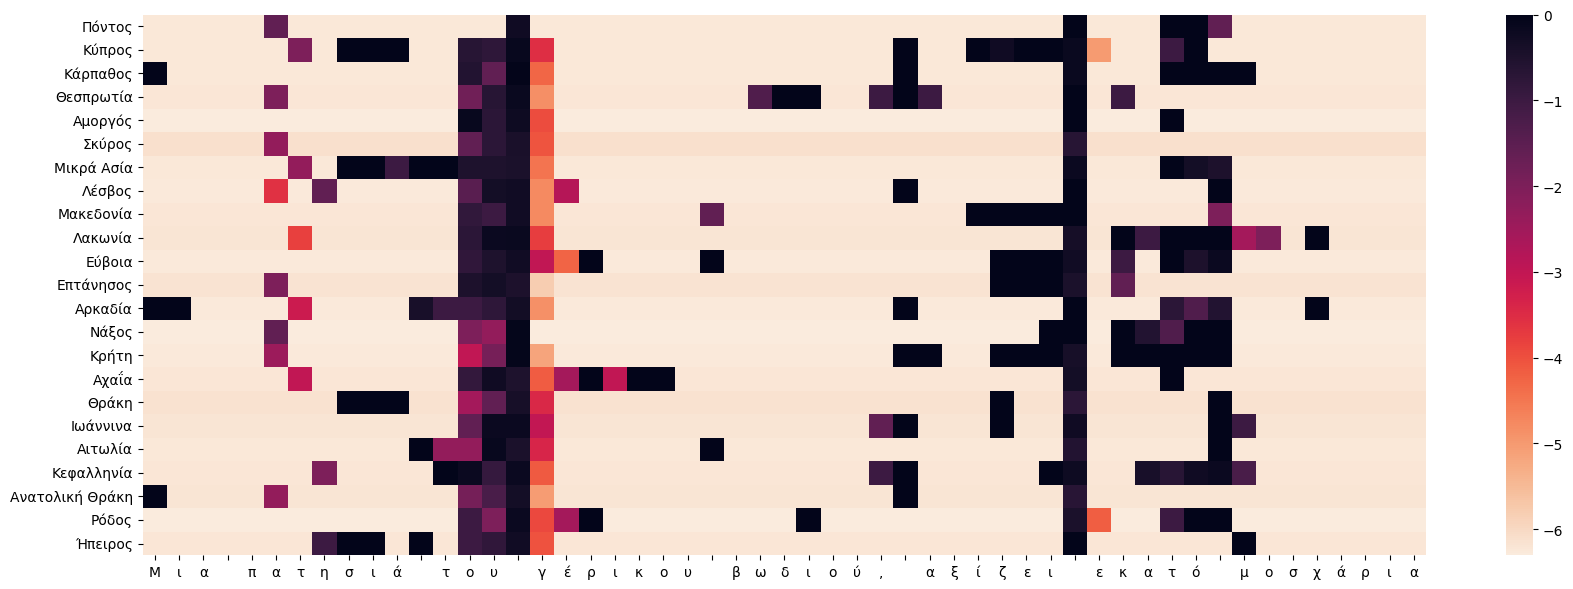

In [60]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [61]:
from sklearn.metrics import *
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.08      0.09      0.08        23
        Αιτωλία       0.50      0.29      0.37        24
        Αμοργός       0.20      0.14      0.16        22
Ανατολική Θράκη       0.19      0.21      0.20        24
        Αρκαδία       0.21      0.19      0.20        31
          Αχαΐα       0.24      0.25      0.25        32
      Επτάνησος       0.23      0.35      0.28        23
         Εύβοια       0.14      0.20      0.17        20
      Θεσπρωτία       0.17      0.23      0.20        22
          Θράκη       0.20      0.12      0.15        25
       Ιωάννινα       0.18      0.10      0.13        29
       Κάρπαθος       0.33      0.29      0.31        28
     Κεφαλληνία       0.21      0.26      0.23        27
          Κρήτη       0.21      0.30      0.25        30
         Κύπρος       0.60      0.62      0.61        24
         Λέσβος       0.35      0.25      0.29        24
        Λακωνία       0.08    

* The confusion matrix can inform us about the confusion in the predictions

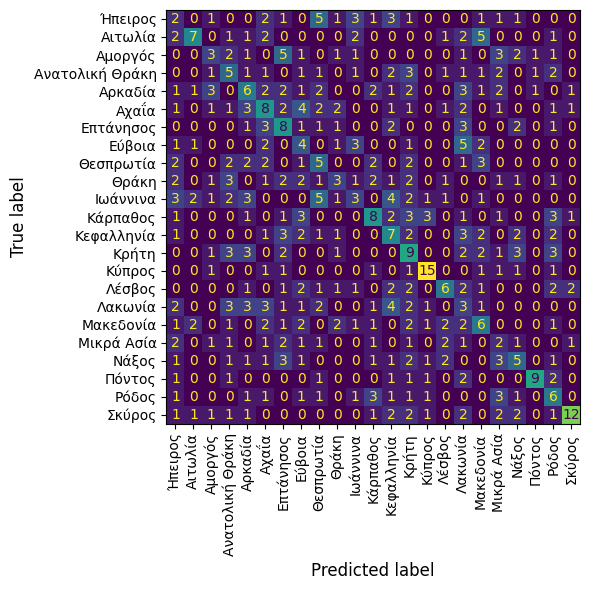

In [62]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

# Text spatial classification
* Trying with a standard text classifier improves slightly the accuracy but similar findings are reported

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

Learning a location classifier on top of character n-grams

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.25)
n-gram: "αρ" 	(tfidf: 0.14)
n-gram: "αρο" 	(tfidf: 0.24)
n-gram: "ιμ" 	(tfidf: 0.22)
n-gram: "ιμί" 	(tfidf: 0.40)
n-gram: "μί" 	(tfidf: 0.25)
n-gram: "μία" 	(tfidf: 0.37)
n-gram: "οι" 	(tfidf: 0.15)
n-gram: "οιμ" 	(tfidf: 0.31)
n-gram: "πα" 	(tfidf: 0.13)
n-gram: "παρ" 	(tfidf: 0.21)
n-gram: "παρο" 	(tfidf: 0.39)
n-gram: "ρο" 	(tfidf: 0.15)
n-gram: "ροι" 	(tfidf: 0.31)


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# benchmarking text classification algorithms
def benchmark_clf(train, dev, test):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        txt_preds = locator.predict(dev.text.values) 
        print(f'{algo_name}: {accuracy_score(dev.area.values, txt_preds):.3f}') # <- accuracy is fine for balanced data

benchmark_clf(train, dev, test)

SVM: 0.303
Forest: 0.259
LR: 0.299


In [72]:
# training and assessing the best model on test data
from sklearn.svm import SVC
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())]) 
locator.fit(train.text.values, train.area.values) 
predictions = locator.predict(test.text.values) 
print(classification_report(test.area.values, predictions))

                 precision    recall  f1-score   support

        Ήπειρος       0.23      0.13      0.17        23
        Αιτωλία       0.36      0.62      0.45        24
        Αμοργός       0.14      0.18      0.16        22
Ανατολική Θράκη       0.25      0.17      0.20        24
        Αρκαδία       0.33      0.19      0.24        31
          Αχαΐα       0.36      0.28      0.32        32
      Επτάνησος       0.28      0.48      0.35        23
         Εύβοια       0.08      0.05      0.06        20
      Θεσπρωτία       0.25      0.27      0.26        22
          Θράκη       0.22      0.16      0.19        25
       Ιωάννινα       0.13      0.10      0.12        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.33      0.41      0.37        27
          Κρήτη       0.41      0.30      0.35        30
         Κύπρος       0.80      0.83      0.82        24
         Λέσβος       0.41      0.46      0.43        24
        Λακωνία       0.11    

# Classifying multi-located proverbs

* Such a classifier can give an estimate about the origins of proverbs multiply located  

In [75]:
duplicates.insert(4, "prediction", locator.predict(duplicates.index.values))
probs = locator.predict_proba(duplicates.index.values)
duplicates.insert(5, "confidence", probs.max(1))
duplicates.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicates.sort_values(by="confidence", ascending=False).head(20)

place  \
text                                                                                               
Όπου γάιδαρος κι αυτός σαμάρι                                      {Αρκαδία, Γορτυνία, Ιωάννινα}   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                {Αιτωλία, Αμβρακιά, Αρκαδία, Γορτυνία, Λάστα}   
Αυτός είναι μη μου άπτου                                            {Ιωάννινα, Νεγάδες, Αμοργός}   
Αυτός είναι ανεμόμυλος                         {Ανατολική Θράκη, Αχαΐα, Πάτρα, Μικρά Ασία, Κυ...   
Μ' πήρι τ' αυτιά                                            {Ήπειρος, Ζαγόρι, Ιωάννινα, Νεγάδες}   
Δεν έχ' νύχια να ξυθή                                   {Ιωάννινα, Μέγα Περιστέρι, Αδριανούπολη}   
Αυτός είναι διάβολος με τα κέρατα                  {Αχαΐα, Πάτρα, Μικρά Ασία, Κύζικος, Πάνορμος}   
Μασά τα λόγια του                                                        {Θράκη, Αίνος, Αμοργός}   
Τουμ πέθανι στου ξύλου                                      {Ήπειρος, Ζαγόρι, Ιωάννινα, Νεγάδες}   
Πάρτ' τουν στου γάμου σ' να σ' πη κι τ' χρόν'                          {Σάμος, Ήπειρος, Δολιανά}   
Τα ράσα δεν κάνουν τον παπά                                 {Αρκαδία, Γορτυνία, Σέρβος, Λακωνία}   
Αυτός είνι κατέβα να φάμι                                 {Σάμος, Μαραθόκαμπος, Λέσβος, Πλωμάρι}   
Ούτι κλαίει ούτι γιλάει                                   {Κοζάνη, Καταφύγιο, Ιωάννινα, Νεγάδες}   
Κουβέντα κουβεντούλα τρώει ο λύκος τη βετούλα      {Θεσπρωτία, Παραμυθιά, Ιωάννινα, Χουλιαράδες}   
Τα λόγια κουμέρκι δεν έχουν                                                  {Θεσσαλία, Λακωνία}   
Κάτσε στ' αυγά σ                                 {Μακεδονία, Βογατσικό, Θράκη, Πετροχώρι Μετρών}   
Λείπει ο Μάρτης από την σαρακοστή;                                      {Ιθάκη, Ανωγή, Ιωάννινα}   
Γέρασι κι γνώσ' στου κιφάλ' τ' δεν έβαλε                    {Ήπειρος, Ζαγόρι, Ιωάννινα, Νεγάδες}   
Τ' δίν' απού τ' χαψιά τ'                                    {Ήπειρος, Ζαγόρι, Ιωάννινα, Νεγάδες}   
Λόγια του κόσμου                                                             {Άνδρος, Επτάνησος}   

                                               place_num  \
text                                                       
Όπου γάιδαρος κι αυτός σαμάρι                          2   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                    2   
Αυτός είναι μη μου άπτου                               2   
Αυτός είναι ανεμόμυλος                                 3   
Μ' πήρι τ' αυτιά                                       2   
Δεν έχ' νύχια να ξυθή                                  2   
Αυτός είναι διάβολος με τα κέρατα                      2   
Μασά τα λόγια του                                      2   
Τουμ πέθανι στου ξύλου                                 2   
Πάρτ' τουν στου γάμου σ' να σ' πη κι τ' χρόν'          2   
Τα ράσα δεν κάνουν τον παπά                            2   
Αυτός είνι κατέβα να φάμι                              2   
Ούτι κλαίει ούτι γιλάει                                2   
Κουβέντα κουβεντούλα τρώει ο λύκος τη βετούλα          2   
Τα λόγια κουμέρκι δεν έχουν                            2   
Κάτσε στ' αυγά σ                                       2   
Λείπει ο Μάρτης από την σαρακοστή;                     2   
Γέρασι κι γνώσ' στου κιφάλ' τ' δεν έβαλε               2   
Τ' δίν' απού τ' χαψιά τ'                               2   
Λόγια του κόσμου                                       2   

                                                                               area  \
text                                                                                  
Όπου γάιδαρος κι αυτός σαμάρι                                   {Αρκαδία, Ιωάννινα}   
Πίσου είνι του πουτήρ' μι τ' ρίγαν'                              {Αρκαδία, Αιτωλία}   
Αυτός είναι μη μου άπτου                                        {Ιωάννινα, Αμοργός}   
Αυτός είναι ανεμόμυλος                         {Ανατολική Θράκη, Μικρά Ασία, Αχαΐα}   
Μ' πήρι τ' αυτιά                               

# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [79]:
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

* R2 is the coefficient of determination, measuring how well a statistical model predicts the model's dependent variable (the outcome).

In [80]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 0.401
R2 (dev): 0.063


In [81]:
predicted_coords = linear.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.40 & 2.05
MSE of lat and lon: 3.05 & 6.93


* Another measure is accuracy, defined based on some threshold.
* For example, measuring the number of texts whose lat, lon, lat and lon, was predicted within some threshold (e.g., 0.5, 1, 1.5).  

In [82]:
acc = pd.DataFrame({"gold_lat": test.lat.values, "gold_lon": test.lon.values, 
                    "pred_lat": predicted_coords[:, 0], "pred_lon": predicted_coords[:, 1]})

legit_lat, legit_lon = [], []
thresholds = [t/10. for t in range(30)]
for th in thresholds: 
    legit_lat.append(100*acc[acc.apply(lambda row: abs(row.gold_lat-row.pred_lat)<th, 1)].shape[0]/acc.shape[0])
    legit_lon.append(100*acc[acc.apply(lambda row: abs(row.gold_lon-row.pred_lon)<th, 1)].shape[0]/acc.shape[0])

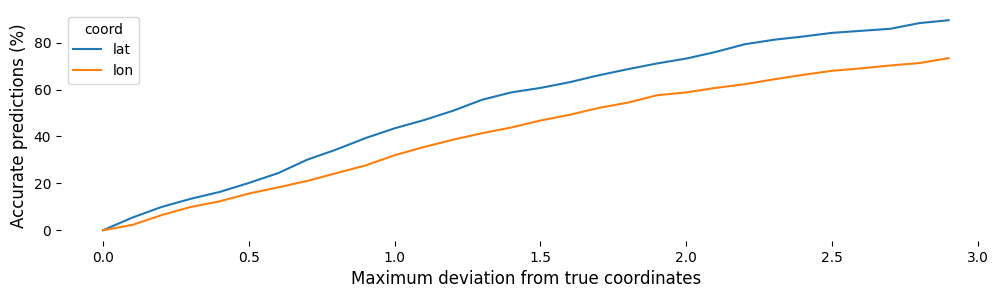

In [83]:
plt.rcParams["figure.figsize"] = (12,3)
d = pd.DataFrame({"accurate": legit_lat+legit_lon, 'threshold':thresholds+thresholds, 'coord':['lat']*len(thresholds)+['lon']*len(thresholds)})
ax = sns.lineplot(d, y="accurate", x="threshold", hue='coord')
ax.set(ylabel="Accurate predictions (%)", xlabel="Maximum deviation from true coordinates");
sns.set_style('darkgrid'); sns.despine(left=True, bottom=True)

In [84]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing $\uparrow$ north (higher lat)


In [85]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

feature       lat       lon
1379  ποντίκια  5.136926 -8.683805
863     κούτρα  4.304629 -5.719972
1710     φωλιά  4.294327 -1.712026
1083      μονό  4.087740 -1.728229
290    βαρβάρα  3.978256  7.411059

* n-grams pushing $\downarrow$ south (lower lat)


In [86]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

feature       lat        lon
1567      τζ -4.618348  12.836957
1655      υό -4.310197   4.380165
977    μάθια -4.233431   1.536180
619    εύρης -4.227920   7.009837
764   καλλιά -4.192802   0.286567

* n-grams pushing $\rightarrow$ east (higher lon)


In [87]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

feature       lat        lon
1567      τζ -4.618348  12.836957
1327  πελλού -3.673916  10.976584
1571     τζι -3.831815  10.453574
1569    τζαι -3.738204  10.430658
217    αντάν -3.700554   9.879195

* n-grams pushing $\leftarrow$ west (lower lon)


In [88]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

feature       lat       lon
1379  ποντίκια  5.136926 -8.683805
1445    σάββας -0.401888 -7.658897
45         άσε  1.266300 -7.261810
1773      ψηλή -2.867807 -6.803888
1428      ράβε  3.243132 -6.345308

# Proverb alteration

* We alread observed that duplicates exist, but near duplicates may also be present, due to spatial propagation.
* We investigate this hypothesis, by measuring the edit distance per proverb, using ones co-existing in many areas.

In [89]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

place  \
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Ήπειρος, Κόνιτσα, Βούρμπιανη, Κρήτη, Κυδωνία,...   
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Ιωάννινα, Χουλιαράδες, Καστοριά, Απόσκεπος, Σ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Κρήτη, Θράκη, Αυδήμιο, Αργολίδα, Ερμιονίδα, Κ...   

                                                place_num  \
text                                                        
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει         45   
Στου κουφού την πόρτα όσο θέλεις βρόντα                26   
Ανεμομαζώματα, διαβολοσκορπίσματα                      28   

                                                                                             area  \
text                                                                                                
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  {Κρήτη, Πήλιο, Θεσπρωτία, Ιωάννινα, Νάξος, Κύπ...   
Στου κουφού την πόρτα όσο θέλεις βρόντα         {Πέλλα, Κρήτη, Φωκίδα, Σέρρες, Κεφαλληνία, Άνδ...   
Ανεμομαζώματα, διαβολοσκορπίσματα               {Τήλος, Θράκη, Εύβοια, Κρήτη, Κως, Μακεδονία, ...   

                                                area_num prediction  \
text                                                                  
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει        23  Θεσπρωτία   
Στου κουφού την πόρτα όσο θέλεις βρόντα               20      Θράκη   
Ανεμομαζώματα, διαβολοσκορπίσματα                     18      Κρήτη   

                                                confidence  \
text                                                         
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει    0.091298   
Στου κουφού την πόρτα όσο θέλεις βρόντα           0.148896   
Ανεμομαζώματα, διαβολοσκορπίσματα                 0.243233   

                                                                                           latlon  
text                                                                                               
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει  [(35.3084952, 24.46334231842296), (39.3650875,...  
Στου κουφού την πόρτα όσο θέλεις βρόντα         [(40.7541229, 22.517832973183303), (35.3084952...  
Ανεμομαζώματα, διαβολοσκορπίσματα               [(36.42930045, 27.31633943341712), (40.8464241...

Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [91]:
%%capture
!pip install python-Levenshtein
from Levenshtein import distance as lev

In [92]:
i = 0
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
near_duplicates

text  \
4879        Η γλώσσα κόκκαλα δεν έχι και κόκκαλα τσακίζ'   
8950       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει   
12296        Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακά   
12297       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακκά   
14088   Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει   
14089   Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει   
19761      Η γλώσσα κόκκαλα δεν έχει μα κόκκαλα τσακίζει   
28103       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
37378         Η γλώσσα κόκκαλα δεν έχει κόκκαλα τσακίζει   
54176       Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει   
57545     Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει   
60624       Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει   
61122       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'   
63213       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
65997       Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει   
91835       Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'   
96914       Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί   
101159  Η γλώσσα κόκκαλα δεν έχει τσαι κόκκαλα τσατσίζει   
114131   Η γλώσσα κόκκαλα δεν έχει, και κόκκαλα τσακίζει   
115017     Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει   
119125    Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζ'ει   

                               place  \
4879        Θράκη, Σαράντα Εκκλησίες   
8950            Μακεδονία, Βογατσικό   
12296                          Ρόδος   
12297                          Ρόδος   
14088                      Κως, Πυλί   
14089                      Κως, Πυλί   
19761   Μακεδονία, Σισάνι, Λιμπόχοβο   
28103                   Θράκη, Βιζύη   
37378               Θράκη, Περιστερά   
54176                   Αδριανούπολη   
57545                         Κύπρος   
60624                   Αδριανούπολη   
61122         Θράκη, Μάλγαρα, Αλμαλή   
63213    Κρήτη, Ινναχώριο, Περιβόλια   
65997             Νάουσα, Στενήμαχος   
91835                 Θράκη, Μάδυτος   
96914                Θράκη, Σωζόπολη   
101159                        Σκύρος   
114131                     Μακεδονία   
115017                       Ρούμελη   
119125             Κοζάνη, Καταφύγιο   

                                              uri  \
4879    http://hdl.handle.net/20.500.11853/169165   
8950    http://hdl.handle.net/20.500.11853/165301   
12296   http://hdl.handle.net/20.500.11853/170697   
12297   http://hdl.handle.net/20.500.11853/186599   
14088   http://hdl.handle.net/20.500.11853/179636   
14089   http://hdl.handle.net/20.500.11853/195775   
19761   http://hdl.handle.net/20.500.11853/172414   
28103   http://hdl.handle.net/20.500.11853/164735   
37378   http://hdl.handle.net/20.500.11853/164689   
54176   http://hdl.handle.net/20.500.11853/168157   
57545   http://hdl.handle.net/20.500.11853/193359   
60624   http://hdl.handle.net/20.500.11853/168157   
61122   http://hdl.handle.net/20.500.11853/164281   
63213   http://hdl.handle.net/20.500.11853/161199   
65997   http://hdl.handle.net/20.500.11853/161010   
91835   http://hdl.handle.net/20.500.11853/165008   
96914   http://hdl.handle.net/20.500.11853/191796   
101159  http://hdl.handle.net/20.500.11853/195491   
114131  http://hdl.handle.net/20.500.11853/169483   
115017  http://hdl.handle.net/20.500.11853/197656   
119125  http://hdl.handle.net/20.500.11853/181938   

                             collector          area        lat        lon  \
4879             Βαφείδης, Θεολόγης Γ.         Θράκη  40.846424  25.875938   
8950             Γρέζος, Τριαντάφυλλος     Μακεδονία  40.686024  23.693434   
12296           Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418   
12297           Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418   
14088             Ζάρακας, Νικόλαος Α.           Κως  36.793693  27.084827   
14089             Ζάρακας, Νικόλαος Α.           Κως  36.793693  27.084827   
19761                   Ιωαννίδης, Αθ.     Μακεδονία  40.686024  23.693434   
28103                Ιωαννίδης, Σάββας         Θράκη  40.84

* Finding areas in the near duplicates but not in the (exact text) duplicates

In [93]:
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)

6
{'Ρόδος', 'Μακεδονία', 'Κως', 'Νάουσα', 'Αδριανούπολη', 'Σκύρος'}


* Checking if an indirect path between two places is as short or shorter than the direct path.

In [94]:
import networkx as nx

# Calculate direct distances matrix.

n = len(near_duplicates)
direct_dist_matrix = np.zeros((n, n))

for u in range(n):
    for v in range(n):
        direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

# Now calculate shortest paths, not necessarily direct.

dist_matrix = np.zeros((n, n))
G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
indirect_shortest_paths = {}
num_indirect_shortest_paths = 0
for u in range(n):
    for v in range(n):
        u_v_shortest_paths = nx.all_shortest_paths(G, u, v, weight='weight')
        for path in u_v_shortest_paths:
            if len(path) > 2:
                if u not in indirect_shortest_paths:
                    indirect_shortest_paths[u] = { }
                if v not in indirect_shortest_paths[u]:
                    indirect_shortest_paths[u][v] = []
                indirect_shortest_paths[u][v].append(path)
                num_indirect_shortest_paths += 1
        if direct_dist_matrix[u][v] != 0:
            dist_matrix[u][v] = shortest_path_lengths[u][v]

In [108]:
def has_no_consecutive_duplicates(lst):
    for a, b in zip(lst, lst[1:]):
        if a == b:
            return False
    return True

for u, v_paths in indirect_shortest_paths.items():
    for v, paths in v_paths.items():
        decoded_paths = [ 
            [near_duplicates['area'].iloc[node] for node in path] 
            for path in paths
        ]
        decoded_paths = [ 
            dp for dp in decoded_paths
            if has_no_consecutive_duplicates(dp) and dp[0] != dp[-1] 
        ]
        if len(decoded_paths) > 0:
            print(f'{u}-{v}: {paths} -> {decoded_paths}')

0-14: [[0, 12, 14], [0, 15, 14], [0, 1, 14], [0, 12, 1, 14], [0, 15, 1, 14]] -> [['Θράκη', 'Μακεδονία', 'Νάουσα']]
1-20: [[1, 19, 20]] -> [['Μακεδονία', 'Ρούμελη', 'Κοζάνη']]
2-8: [[2, 19, 8]] -> [['Ρόδος', 'Ρούμελη', 'Θράκη']]
2-14: [[2, 19, 14], [2, 1, 14]] -> [['Ρόδος', 'Ρούμελη', 'Νάουσα'], ['Ρόδος', 'Μακεδονία', 'Νάουσα']]
2-20: [[2, 19, 20]] -> [['Ρόδος', 'Ρούμελη', 'Κοζάνη']]
3-8: [[3, 19, 8]] -> [['Ρόδος', 'Ρούμελη', 'Θράκη']]
3-14: [[3, 19, 14], [3, 1, 14]] -> [['Ρόδος', 'Ρούμελη', 'Νάουσα'], ['Ρόδος', 'Μακεδονία', 'Νάουσα']]
3-20: [[3, 19, 20]] -> [['Ρόδος', 'Ρούμελη', 'Κοζάνη']]
4-8: [[4, 19, 8]] -> [['Κως', 'Ρούμελη', 'Θράκη']]
4-12: [[4, 1, 12], [4, 0, 12]] -> [['Κως', 'Μακεδονία', 'Θράκη']]
4-14: [[4, 19, 14], [4, 1, 14]] -> [['Κως', 'Ρούμελη', 'Νάουσα'], ['Κως', 'Μακεδονία', 'Νάουσα']]
4-15: [[4, 1, 15], [4, 0, 15]] -> [['Κως', 'Μακεδονία', 'Θράκη']]
4-20: [[4, 19, 20]] -> [['Κως', 'Ρούμελη', 'Κοζάνη']]
5-8: [[5, 19, 8]] -> [['Κως', 'Ρούμελη', 'Θράκη']]
5-12: [[5, 1, 12]

In [109]:
i = 1
target = highly_distr.reset_index().iloc[i].text
print(target)
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates

Στου κουφού την πόρτα όσο θέλεις βρόντα
19
{'Ηλεία', 'Σάμος', 'Ρόδος', 'Κως', 'Κέρκυρα', 'Κάρπαθος', 'Μήλος', 'Κύπρος', 'Κορινθία', 'Αχαΐα', 'Χίος', 'Αργολίδα', 'Δαρδανέλλια (Ελλήσποντος)', 'Αδριανούπολη', 'Εύβοια', 'Λέσβος', 'Μακεδονία', 'Ήπειρος', 'Μικρά Ασία'}


text  \
544        Σ του κουφού την πόρτα όσο θέλεις βρόντα   
4730       Σ του κουφού την πόρτα όσο θέλεις βρόντα   
6886       Στου κουφού την πόρτα, όσο θέλεις βρόντα   
7261        Στου κουφού τη πόρτα, όσο θέλεις βρόντα   
9704         Στου κουφού την μπόρτα όσο θέλς βρόντα   
9867         Τού κουφού την πόρτα όσο θέλεις βρόντα   
10434      Σ του κουφού την πόρτα όσο θέλεις βρόντα   
13200       Στου κουφού τη πόρτα, όσο θέλεις βρόντα   
13201        Στου κουφού τημ πόρτα όσο θέλης βρόντα   
13801     Στου κουφού την πόρταν όσον θέλεις βρόντα   
14241       Στου κουφού τη μπόρτα όσο θέλεις βρόντα   
14242       Στου κουφού τη μπόρτα όσο θέλεις βρόντα   
19590      Στου κουφού την πόρταν όσο θέλεις βρόντα   
19591     Στου κουφού την πόρταν, όσο θέλεις βρόντα   
19910      Σ του κουφού την πόρτα όσο θέλεις βρόντα   
28009      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
28144       Σ του κουφού την πόρτα όσο θέλεις βρότα   
28390       Στου κουφού τη μπόρτα όσο θελεις βρόντα   
37261       Στου κουφού τημ πόρτα όσο θέλεις βρόντα   
40144        Στου κωφού την πόρτα όσο θέλεις βρόντα   
40912     Σ του κουφού την πόρτα όσον θέλεις βρόντα   
45769         Στου κουφού τη bόρτα όσο θέλεις βρόdα   
45770        Στου κουφού τη bόρτα όσο θέλεις βρόντα   
51674      Σ του κουφού τημ πόρτα όσο θέλεις βρόντα   
51929       Στου κουφού τημ πόρτα όσο θέλης βρόντα!   
51930        Στου κουφού την πόρτα όσο θέλης βρόντα   
53298      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
54444      Σ του κουφού την πόρτα όσον θέλ'ς βρόντα   
54445     Σ του κουφού την πόρτα όσον θέλεις βρόντα   
55672      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
55784    Σ του κουφού την πόρταν όσον θέλεις βρόντα   
55919     Στου κουφού την πόρταν όσον θέλεις βρόντα   
60541     Στου κουφού την πόρταν όσον θέλεις βρόντα   
60899      Σ του κουφού την πόρτα όσον θέλ'ς βρόντα   
60900     Σ του κουφού την πόρτα όσον θέλεις βρόντα   
62367     Στου κουφού την πόρταν, όσα θέλεις βρόντα   
64600      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
64601      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
64602      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
64603      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
64604      Στου κουφού την πόρτα, όσο θέλεις βρόντα   
67810        Στου κουφού την bόρτα όσο θέλεις βρόdα   
67811      Στου κουφού την πόρτα, όσο θέλης βρόντα!   
68433       Τού κουφού την πόρτα, όσο θέλεις βρόντα   
73771      Σ του κουφού την πόρτα όσο θέλεις βρόντα   
76273   Σ του κουφού την πόρταν, όσον θέλεις βρόντα   
76308       Στου κουφού τη πόρταν όσο θέλεις βρόντα   
78524       Στου κουφού τη bόρτα, όσο θέλεις βρόντα   
79890     Σ του κουφού την πόρταν όσο θέλεις βρόντα   
81192       Στου κουφού τεν πόρτα όσο θέλεις βρόντα   
93836      Στου κουφού τημ πόρτα, όσο θέλεις βρόντα   
104243     Σ του κουφού την πόρτα όσο θέλεις βρόντα   
105052      Στου κουφού τη μπόρτα όσο θέλεις βρόντα   
105053      Στου κουφού τημ πόρτα όσο θέλεις βρόντα   
108720     Στου κουφού την πόρτα όσον θέλεις βρόντα   
109128     Σ' τού κουφού τη πόρτα όσο θέλεις βρόντα   
110633     Στου κουφού την πόρτα, όσο θέλεις βρόντα   
113313     Στου κουφού την πόρτα, όσο θέλεις βρόντα   
114762      Στου κωφού την πόρτα, όσο θέλεις βρόντα   
118319     Στου κουφού την πόρτα, όσο θέλεις βρόντα   

                                 place  \
544                       Εύβοια, Κύμη   
4730         Δαρδανέλλια (Ελλήσποντος)   
6886                            Άνδρος   
7261            Κοζάνη, Βόϊο, Γαλατινή   
9704                    Θράκη, Αυδήμιο   
9867                           Ρούμελη   
10434                  Θράκη, Σηλυβρία   
13200                            Ρόδος   
13201                            Ρόδος   
13801                           Κύπρος   
14241                        Κως, Πυλί   
14242                        Κως, Πυλί   
19590               Κύπρος, Λευκόνοικο   
19591               Κύπρος, Λευκόνοικο   
19910     Μακεδονία, Σισάνι, Λιμπόχοβο   
28009              

In [110]:
n = len(near_duplicates)
direct_dist_matrix = np.zeros((n, n))

for u in range(n):
    for v in range(n):
        direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

# Now calculate shortest paths, not necessarily direct.

dist_matrix = np.zeros((n, n))
G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
indirect_shortest_paths = {}
num_indirect_shortest_paths = 0
for u in range(n):
    for v in range(n):
        u_v_shortest_paths = nx.all_shortest_paths(G, u, v, weight='weight')
        for path in u_v_shortest_paths:
            if len(path) > 2:
                if u not in indirect_shortest_paths:
                    indirect_shortest_paths[u] = { }
                if v not in indirect_shortest_paths[u]:
                    indirect_shortest_paths[u][v] = []
                indirect_shortest_paths[u][v].append(path)
                num_indirect_shortest_paths += 1
        if direct_dist_matrix[u][v] != 0:
            dist_matrix[u][v] = shortest_path_lengths[u][v]
            
for u, v_paths in indirect_shortest_paths.items():
    for v, paths in v_paths.items():
        decoded_paths = [ 
            [near_duplicates['area'].iloc[node] for node in path] 
            for path in paths
        ]
        decoded_paths = [ dp for dp in decoded_paths 
                         if has_no_consecutive_duplicates(dp) and dp[0] != dp[-1] ]
        if len(decoded_paths) > 0:
            print(u, v, paths, decoded_paths)

0 1 [[0, 16, 1], [0, 20, 1], [0, 23, 1], [0, 28, 1], [0, 34, 1], [0, 48, 1]] [['Εύβοια', 'Θράκη', 'Δαρδανέλλια (Ελλήσποντος)'], ['Εύβοια', 'Χίος', 'Δαρδανέλλια (Ελλήσποντος)'], ['Εύβοια', 'Αχαΐα', 'Δαρδανέλλια (Ελλήσποντος)'], ['Εύβοια', 'Αδριανούπολη', 'Δαρδανέλλια (Ελλήσποντος)'], ['Εύβοια', 'Αδριανούπολη', 'Δαρδανέλλια (Ελλήσποντος)'], ['Εύβοια', 'Μικρά Ασία', 'Δαρδανέλλια (Ελλήσποντος)']]
0 3 [[0, 2, 3], [0, 15, 3], [0, 26, 3], [0, 29, 3], [0, 36, 3], [0, 37, 3], [0, 38, 3], [0, 39, 3], [0, 40, 3], [0, 56, 3], [0, 57, 3], [0, 59, 3]] [['Εύβοια', 'Άνδρος', 'Κοζάνη'], ['Εύβοια', 'Θεσπρωτία', 'Κοζάνη'], ['Εύβοια', 'Ηλεία', 'Κοζάνη'], ['Εύβοια', 'Κρήτη', 'Κοζάνη'], ['Εύβοια', 'Μικρά Ασία', 'Κοζάνη'], ['Εύβοια', 'Κρήτη', 'Κοζάνη'], ['Εύβοια', 'Μικρά Ασία', 'Κοζάνη'], ['Εύβοια', 'Μικρά Ασία', 'Κοζάνη'], ['Εύβοια', 'Λακωνία', 'Κοζάνη'], ['Εύβοια', 'Θράκη', 'Κοζάνη'], ['Εύβοια', 'Αρκαδία', 'Κοζάνη'], ['Εύβοια', 'Θράκη', 'Κοζάνη']]
0 6 [[0, 16, 6], [0, 20, 6], [0, 23, 6], [0, 28, 6], [0, 34

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43 27 [[43, 5, 27], [43, 2, 27], [43, 15, 27], [43, 26, 27], [43, 29, 27], [43, 36, 27], [43, 37, 27], [43, 38, 27], [43, 39, 27], [43, 40, 27], [43, 56, 27], [43, 57, 27], [43, 59, 27], [43, 0, 27], [43, 5, 0, 27], [43, 2, 0, 27], [43, 15, 0, 27], [43, 26, 0, 27], [43, 29, 0, 27], [43, 36, 0, 27], [43, 37, 0, 27], [43, 38, 0, 27], [43, 39, 0, 27], [43, 40, 0, 27], [43, 56, 0, 27], [43, 57, 0, 27], [43, 59, 0, 27], [43, 1, 27], [43, 5, 1, 27], [43, 2, 1, 27], [43, 15, 1, 27], [43, 26, 1, 27], [43, 29, 1, 27], [43, 36, 1, 27], [43, 37, 1, 27], [43, 38, 1, 27], [43, 39, 1, 27], [43, 40, 1, 27], [43, 56, 1, 27], [43, 57, 1, 27], [43, 59, 1, 27], [43, 6, 27], [43, 5, 6, 27], [43, 2, 6, 27], [43, 15, 6, 27], [43, 26, 6, 27], [43, 29, 6, 27], [43, 36, 6, 27], [43, 37, 6, 27], [43, 38, 6, 27], [43, 39, 6, 27], [43, 40, 6, 27], [43, 56, 6, 27], [43, 57, 6, 27], [43, 59, 6, 27], [43, 14, 27], [43, 5, 14, 27], [43, 2, 14, 27], [43, 15, 14, 27], [43, 26, 14, 27], [43, 29, 14, 27], [43, 36, 14, 27

In [111]:
i = 2
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates.sort_values("lev", ascending=False).head(20)

17
{'Σκύρος', 'Θεσσαλία', 'Ρόδος', 'Βοιωτία', 'Ημαθία', 'Φιλιππούπολη', 'Επτάνησος', 'Θεσπρωτία', 'Αιτωλοακαρνανία', 'Ιωάννινα', 'Ρούμελη', 'Νίσυρος', 'Ανατολική Θράκη', 'Σάμος', 'Κύπρος', 'Κεφαλληνία', 'Λακωνία'}


text                           place  \
79527       Ανεμουμαζώματα διαβοσκορπίσματα  Μικρά Ασία, Λιβίσσι (Λειβίσσι)   
94119     Ανεμομαζώματα, δαιμονοσκορπίσματα                   Κρήτη, Σητεία   
98218   Ανεμομαζώματα διαβουλουσκουρπίσματα                    Αδριανούπολη   
100770    Ανεμομαζώματα, δαιμονοσκορπίσματα                          Σκύρος   
62444    Ανιμουμαζώματα διαβουλοσκορπίσματα                    Αδριανούπολη   
56358     Ανεμομαζώματα, δαιμονοσκορπίσματα                          Κύπρος   
11947       Ανεμομαδέματα διαολοσκορπίσματα                           Ρόδος   
41532      Ανεμομαζώματα, δαιμοοσκορπίσματα                        Ιωάννινα   
36061   Ανεμομαζέματα, δια(β)ολοσκορπίσματα                         Νίσυρος   
98217      Ανεμομάζωματα, διαολοσκορπίσματα        Θράκη, Σαράντα Εκκλησίες   
120398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
121398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
42356       Ανεμομαξώματα διαολοσκορπίσματα         Κρήτη, Ρέθυμνο, Μαλλάκι   
122398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
134398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
124398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
129398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
133398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
132398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   
131398     Ανεμομαζώματα διαουλοσκορπίσματα                           Σάμος   

                                              uri  \
79527   http://hdl.handle.net/20.500.11853/153830   
94119   http://hdl.handle.net/20.500.11853/189090   
98218   http://hdl.handle.net/20.500.11853/196946   
100770  http://hdl.handle.net/20.500.11853/195161   
62444   http://hdl.handle.net/20.500.11853/186040   
56358   http://hdl.handle.net/20.500.11853/194481   
11947   http://hdl.handle.net/20.500.11853/142563   
41532   http://hdl.handle.net/20.500.11853/147957   
36061   http://hdl.handle.net/20.500.11853/186837   
98217   http://hdl.handle.net/20.500.11853/197065   
120398  http://hdl.handle.net/20.500.11853/185814   
121398  http://hdl.handle.net/20.500.11853/185814   
42356   http://hdl.handle.net/20.500.11853/148071   
122398  http://hdl.handle.net/20.500.11853/185814   
134398  http://hdl.handle.net/20.500.11853/185814   
124398  http://hdl.handle.net/20.500.11853/185814   
129398  http://hdl.handle.net/20.500.11853/185814   
133398  http://hdl.handle.net/20.500.11853/185814   
132398  http://hdl.handle.net/20.500.11853/185814   
131398  http://hdl.handle.net/20.500.11853/185814   

                          collector          area        lat        lon  lev  
79527                      Μουσαίος    Μικρά Ασία  38.184637  23.512277    4  
94119              Παπαδάκη, Ειρήνη         Κρήτη  35.308495  24.463342    4  
98218   Παπαχριστοδούλου, Πολύδωρος  Αδριανούπολη  41.675933  26.558722    4  
100770             Περδίκα, Νίκη Λ.        Σκύρος  38.873044  24.524477    4  
62444     Λαμπουσιάδης, Γεώργιος Ι.  Αδριανούπολη  41.675933  26.558722    4  
56358            Κυριαζής, Νίκος Γ.        Κύπρος  34.982302  33.145128    4  
11947        Δρακίδης, Γεράσιμος Δ.         Ρόδος  36.172630  27.919418    4  
41532         Κατζιούλης, Παρθένιος      Ιωάννινα  39.663982  20.852278    4  
36061          Καζαβής, Γεώργιος Ν.       Νίσυρος  36.589046  27.169184    3  
98217   Παπαχριστοδούλου, Πολύδωρος         Θράκη  40.846424  25.875938    3  
120398                    anonymous         Σάμος  37.724616  26.819292    3  
121398                    anonymous         Σάμος  37.724616  26.819292    3  
42356          Κλαζινού, Αικατερίνη         Κρήτη  35.308495  24.463342    3  
122398                    anonymous         Σάμος  37.724616  26.819292    3  
134398                    anonymous         Σάμος  37.724616  26.819292    3  
1

In [112]:
n = len(near_duplicates)
direct_dist_matrix = np.zeros((n, n))

for u in range(n):
    for v in range(n):
        direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

dist_matrix = np.zeros((n, n))
G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
for u in range(n):
    for v in range(n):        
        if direct_dist_matrix[u][v] != 0:
            dist_matrix[u][v] = shortest_path_lengths[u][v]

shortest_indirect = dist_matrix <= direct_dist_matrix
shortest_indirect.sum()

4096

# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Exploring the three targets discussed above.
* Fetching versions up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [113]:
target = highly_distr.reset_index().iloc[1].text.lower()
target

'στου κουφού την πόρτα όσο θέλεις βρόντα'

* Fetching proverbs up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [114]:
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [115]:
close_candidates = candidates[candidates.lev < 20]
close_candidates.sample(5)

text  \
60541    Στου κουφού την πόρταν όσον θέλεις βρόντα   
7261       Στου κουφού τη πόρτα, όσο θέλεις βρόντα   
64600     Στου κουφού την πόρτα, όσο θέλεις βρόντα   
26238      Στου κουφού την πόρταν όσο θέλεις χτύπα   
88293  Στου κουφού την πόρτα θέλεις βάρε θέλεις μη   

                               place  \
60541                         Κύπρος   
7261          Κοζάνη, Βόϊο, Γαλατινή   
64600  Μικρά Ασία, Βιθυνία, Τρίγλεια   
26238                        Αμοργός   
88293                        Λακωνία   

                                             uri                  collector  \
60541  http://hdl.handle.net/20.500.11853/274337  Κωνσταντίνου, Χαρίλαος Ζ.   
7261   http://hdl.handle.net/20.500.11853/274573    Βουζιανάς, Κωνσταντίνος   
64600  http://hdl.handle.net/20.500.11853/272962            Λιουδάκη, Μαρία   
26238  http://hdl.handle.net/20.500.11853/274231       Ιωαννίδης, Εμμανουήλ   
88293  http://hdl.handle.net/20.500.11853/273521             Νεστορίδης, Κ.   

             area        lat        lon  lev  
60541      Κύπρος  34.982302  33.145128    3  
7261       Κοζάνη  40.300726  21.788312    3  
64600  Μικρά Ασία  38.184637  23.512277    2  
26238     Αμοργός  36.852524  25.898487    7  
88293     Λακωνία  36.760279  22.790464   17

* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage, using the minimum distance between the proverbs of two clusters as a criterion for merging.
* Based on the assumption that the fewer edits reflect the chosen route.  

In [116]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

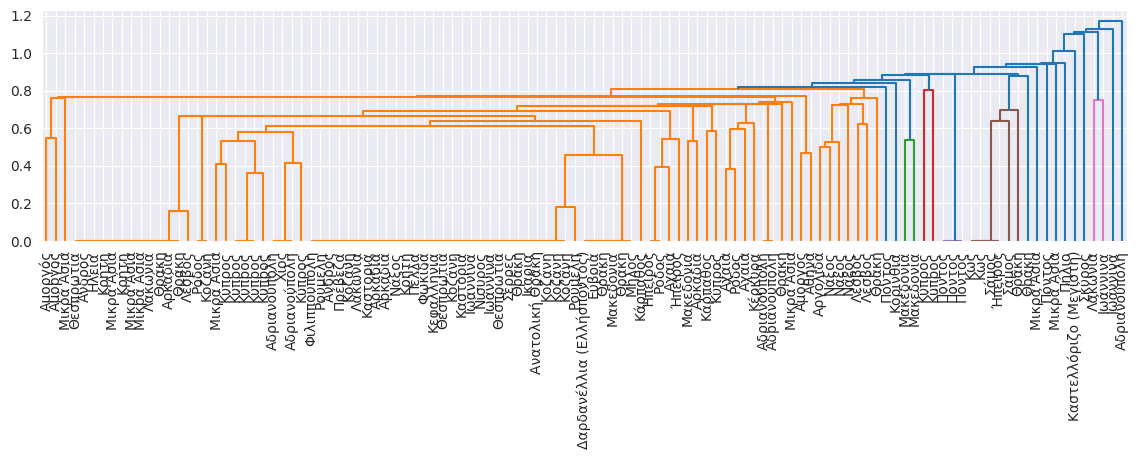

In [117]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(14, 3))
ax = dendrogram(Z, orientation='top', labels=close_candidates.area.values, distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True);
fig.savefig('deaf_man_door.pdf', format="PDF", dpi=300)

* To better understand the clustering, we create a dataframe and filter based on distance

In [118]:
clustering = fcluster(Z, t=0.4, criterion='distance')
close_candidates.insert(6, "clustering", clustering)
#close_candidates["clustering"] = clustering
grouped = close_candidates.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

cluster  \
clustering                                                      
3                                  [Κως, Κως, Σάμος, Ήπειρος]   
7                                    [Πόντος, Πόντος, Πόντος]   
21                               [Αδριανούπολη, Αδριανούπολη]   
22                                             [Ρόδος, Αχαΐα]   
29                                    [Ρόδος, Αχαΐα, Ήπειρος]   
31          [Εύβοια, Δαρδανέλλια (Ελλήσποντος), Θράκη, Μακ...   
32          [Ρούμελη, Φιλιππούπολη, Άνδρος, Πρέβεζα, Κοζάν...   
33                         [Χίος, Αδριανούπολη, Αδριανούπολη]   
35                           [Κύπρος, Κύπρος, Κύπρος, Κύπρος]   
39                                            [Κοζάνη, Ρόδος]   
40          [Άνδρος, Θεσπρωτία, Ηλεία, Κρήτη, Μικρά Ασία, ...   

                                                         text  
clustering                                                     
3           [Στου κουφού τη μπόρτα όσο θέλεις βρόντα, Στου...  
7           [Σ ση κωφού τημ πόρταν όσον θέλεις βρόντα, Σ σ...  
21          [Σ του κουφού την πόρτα όσον θέλ'ς βρόντα, Σ τ...  
22          [Στου κουφού τημ πόρτα όσο θέλης βρόντα, Στου ...  
29          [Στου κουφού τημ πόρτα όσο θέλεις βρόντα, Σ το...  
31          [Σ του κουφού την πόρτα όσο θέλεις βρόντα, Σ τ...  
32          [Στου κουφού την πόρτα όσο θέλεις βρόντα, Στου...  
33          [Σ του κουφού την πόρτα όσον θέλεις βρόντα, Σ ...  
35          [Στου κουφού την πόρταν όσον θέλεις βρόντα, Σ ...  
39          [Στου κουφού τη πόρτα, όσο θέλεις βρόντα, Στου...  
40          [Στου κουφού την πόρτα, όσο θέλεις βρόντα, Στο...

In [119]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Κως --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα
Σάμος --> Στου κουφού τη μπόρτα όσο θελεις βρόντα
Ήπειρος --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλης βρόντα
Αχαΐα --> Στου κουφού τημ πόρτα όσο θέλης βρόντα!

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα
Αχαΐα --> Σ του κουφού τημ πόρτα όσο θέλεις βρόντα
Ήπειρος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα

Εύβοια --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Δαρδανέλλια (Ελλήσποντος) --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Θράκη --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μακεδονία --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μήλος --> Σ του κουφού την πόρτα όσο θέλεις βρόντα

Ρούμελη --> Τού κουφού την πόρτα όσο θέλεις βρόντα
Φιλιππούπολη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Άνδρος --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Πρέβεζα --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Κοζάνη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Λακωνία --> Στου κουφού την πόρτα όσο θέλεις βρόντα


# Proverb propagation

* A synthetic example to convey the picture of the indirect paths introduced above.
* Ιntroducing location-based noise sources, e.g., by adding a nasal (Cyrpus) or /k/>/ts/ (Crete).
* Then, altering proverbs by visiting virtually an area directly (adding noise of one type) or through other areas (adding multiple noises).

In [120]:
from Levenshtein import distance as lev

def nasal(txt):
    out = [ word+"ν" if word[-1] in {"ε","ο","η","α"} else word for word in txt.split() ]
    return " ".join(out)
    
def tsita(txt):
    return txt.replace("κ", "τσ")

source = "η παροιμία για τη παροιμία και τη παράδοση"
cyprus = nasal(source)
crete = tsita(source)
route = nasal(tsita(source))

print(f'{source} -> {cyprus}\n(Source -> Cyprus: {lev(source, cyprus)} edits)')
print(f'{source} -> {crete}\n(Source -> Crete: {lev(source, crete)} edits)')
print(f'{crete} -> {cyprus}\n(Crete -> Cyprus: {lev(crete, route)} edits)')
print(f'{source} -> {route}\n(Source -> Crete -> Cyrpus: {lev(source, route)} edits)')

η παροιμία για τη παροιμία και τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν και την παράδοσην
(Source -> Cyprus: 7 edits)
η παροιμία για τη παροιμία και τη παράδοση -> η παροιμία για τη παροιμία τσαι τη παράδοση
(Source -> Crete: 2 edits)
η παροιμία για τη παροιμία τσαι τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν και την παράδοσην
(Crete -> Cyprus: 7 edits)
η παροιμία για τη παροιμία και τη παράδοση -> ην παροιμίαν γιαν την παροιμίαν τσαι την παράδοσην
(Source -> Crete -> Cyrpus: 9 edits)


* There is a path (Source -> Crete -> Cyprus) whose sum of edit distances equals the distance between the two edges (Source -> Crete and Crete -> Cyprus). 

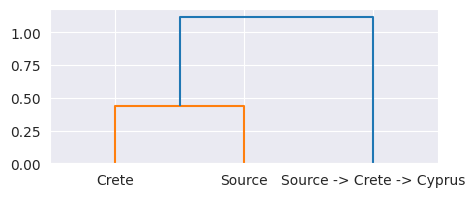

In [121]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform([source, tsita(source), nasal(tsita(source))])
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(5, 2))
ax = dendrogram(Z, 
                orientation='top', 
                labels=["Source", "Crete", "Source -> Crete -> Cyprus"], 
                distance_sort='descending', 
                show_leaf_counts=False, 
                leaf_font_size=10., 
                show_contracted=True)

* The Source proveb is near the Source>Cretan alteration (orange cluster)
* Which is near the Source>Cretan>Cypriotic alteration (blue link) 